## Stage1: Train the base GNN model 
### Dataset:
- Facebook
- Github

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
# !pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html

from torch_geometric.datasets import FacebookPagePage
from torch_geometric.datasets import GitHub

from torch_geometric.transforms import NormalizeFeatures

import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from tqdm.notebook import tqdm

from torch_geometric.nn import GCNConv
import torch.nn.functional as F


2.0.1+cu117


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Facebook

In [3]:
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomNodeSplit(num_val=0.1, num_test=0.1),
])

# Load the dataset
dataset = FacebookPagePage(root='/tmp/FacebookPagePage', transform=transform)
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)

print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...


BadZipFile: File is not a zip file

#### GCN model for Node Prediction

In [ ]:
# train a GCN model for node classification
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(128, 64, cached=True,
                             normalize=True)
        self.conv2 = GCNConv(64, 32, cached=True,
                             normalize=True)
        self.conv3 = GCNConv(32, 4, cached=True,
                             normalize=True)

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.4, training=self.training)
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv3(x, edge_index, edge_weight)
        return x

In [ ]:
# from importlib import reload
# import stage1_model
# reload(stage1_model)
# GNNmodel = stage1_model.FBGCN()

In [ ]:
GNNmodel = GCN()
GNNmodel, data = GNNmodel.to(device), data.to(device)
optimizer = torch.optim.Adam(GNNmodel.parameters(), weight_decay=1e-4)
n_epoch=1000
print(GNNmodel)

In [ ]:
def train():
    GNNmodel.train()
    optimizer.zero_grad()
    out = GNNmodel(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test():
    GNNmodel.eval()
    pred = GNNmodel(data.x, data.edge_index).argmax(dim=-1)
    mask_val = data.val_mask
    mask_test = data.test_mask
    accs_val = (int((pred[mask_val] == data.y[mask_val]).sum()) / int(mask_val.sum()))
    accs_test = (int((pred[mask_test] == data.y[mask_test]).sum()) / int(mask_test.sum()))
    return accs_val, accs_test

In [ ]:
loss_record = []
val_acc_record = []
test_acc_record = []

for epoch in range(1, n_epoch):
    loss = train()
    val_acc, test_acc= test()

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

    loss_record.append(loss)
    val_acc_record.append(val_acc)
    test_acc_record.append(test_acc)

Epoch: 001, Loss: 1.3852, Val: 0.3360, Test: 0.3222
Epoch: 002, Loss: 1.3837, Val: 0.3778, Test: 0.3761
Epoch: 003, Loss: 1.3822, Val: 0.3712, Test: 0.3698
Epoch: 004, Loss: 1.3811, Val: 0.3680, Test: 0.3738
Epoch: 005, Loss: 1.3798, Val: 0.3716, Test: 0.3761
Epoch: 006, Loss: 1.3788, Val: 0.3587, Test: 0.3654
Epoch: 007, Loss: 1.3774, Val: 0.3342, Test: 0.3391
Epoch: 008, Loss: 1.3762, Val: 0.3169, Test: 0.3200
Epoch: 009, Loss: 1.3751, Val: 0.3075, Test: 0.3075
Epoch: 010, Loss: 1.3739, Val: 0.3049, Test: 0.3049
Epoch: 011, Loss: 1.3726, Val: 0.3040, Test: 0.3040
Epoch: 012, Loss: 1.3714, Val: 0.3035, Test: 0.3040
Epoch: 013, Loss: 1.3699, Val: 0.3035, Test: 0.3040
Epoch: 014, Loss: 1.3686, Val: 0.3035, Test: 0.3040
Epoch: 015, Loss: 1.3672, Val: 0.3035, Test: 0.3040
Epoch: 016, Loss: 1.3659, Val: 0.3035, Test: 0.3040
Epoch: 017, Loss: 1.3647, Val: 0.3035, Test: 0.3040
Epoch: 018, Loss: 1.3632, Val: 0.3035, Test: 0.3040
Epoch: 019, Loss: 1.3616, Val: 0.3035, Test: 0.3040
Epoch: 020, 

In [ ]:
# save model
torch.save(GNNmodel, 'model/Facebook/1_GCN_model.pt')
# GNNmodel = torch.load('model/1_GCN_model.pt')

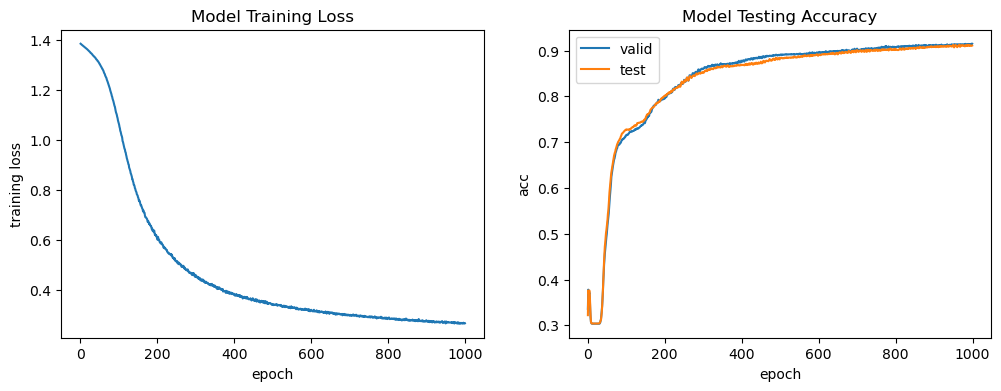

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1, n_epoch), loss_record)
plt.xlabel("epoch")
plt.ylabel("training loss")
plt.title(f"Model Training Loss")


plt.subplot(1,2,2)
plt.plot(range(1, n_epoch), val_acc_record, label='valid')
plt.plot(range(1, n_epoch), test_acc_record, label='test')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("acc")
plt.title(f"Model Testing Accuracy")
plt.savefig('plot/1_GCNresult.png', dpi=300)

plt.show()

<br>

## Github

In [ ]:
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomNodeSplit(num_val=0.1, num_test=0.1),
])

# Load the dataset
dataset = GitHub(root='/tmp/GitHub', transform=transform)
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)

print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...
Done!



Dataset: GitHub():
Number of graphs: 1
Number of features: 128
Number of classes: 2
Data(x=[37700, 128], edge_index=[2, 578006], y=[37700], train_mask=[37700], val_mask=[37700], test_mask=[37700])
Number of nodes: 37700
Number of edges: 578006
Average node degree: 15.33
Number of training nodes: 30160
Training node label rate: 0.80
Has isolated nodes: False
Has self-loops: False
Is undirected: True


#### GCN model for Node Prediction

In [ ]:
# train a GCN model for node classification
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(128, 64, cached=True,
                             normalize=True)
        # self.conv2 = GCNConv(64, 32, cached=True,
        #                      normalize=True)
        self.conv3 = GCNConv(64, 2, cached=True,
                             normalize=True)

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        # x = F.dropout(x, p=0.4, training=self.training)
        # x = self.conv2(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv3(x, edge_index, edge_weight)
        return x

In [5]:
# GNNmodel = stage1_model.GitGCN()
GNNmodel = GCN()
GNNmodel, data = GNNmodel.to(device), data.to(device)
optimizer = torch.optim.Adam(GNNmodel.parameters(), weight_decay=1e-4, lr=0.03)
n_epoch=1000
print(GNNmodel)

In [ ]:
def train():
    GNNmodel.train()
    optimizer.zero_grad()
    out = GNNmodel(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test():
    GNNmodel.eval()
    pred = GNNmodel(data.x, data.edge_index).argmax(dim=-1)
    mask_val = data.val_mask
    mask_test = data.test_mask
    accs_val = (int((pred[mask_val] == data.y[mask_val]).sum()) / int(mask_val.sum()))
    accs_test = (int((pred[mask_test] == data.y[mask_test]).sum()) / int(mask_test.sum()))
    return accs_val, accs_test

In [ ]:
loss_record = []
val_acc_record = []
test_acc_record = []

for epoch in range(1, n_epoch):
    loss = train()
    val_acc, test_acc= test()
    
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')
    
    loss_record.append(loss)
    val_acc_record.append(val_acc)
    test_acc_record.append(test_acc)

Epoch: 001, Loss: 0.6888, Val: 0.7334, Test: 0.7562
Epoch: 002, Loss: 0.6142, Val: 0.7334, Test: 0.7562
Epoch: 003, Loss: 0.5791, Val: 0.7334, Test: 0.7562
Epoch: 004, Loss: 0.5985, Val: 0.7334, Test: 0.7562
Epoch: 005, Loss: 0.6031, Val: 0.7334, Test: 0.7562
Epoch: 006, Loss: 0.5888, Val: 0.7334, Test: 0.7562
Epoch: 007, Loss: 0.5774, Val: 0.7334, Test: 0.7562
Epoch: 008, Loss: 0.5745, Val: 0.7334, Test: 0.7562
Epoch: 009, Loss: 0.5777, Val: 0.7334, Test: 0.7562
Epoch: 010, Loss: 0.5786, Val: 0.7334, Test: 0.7562
Epoch: 011, Loss: 0.5782, Val: 0.7334, Test: 0.7562
Epoch: 012, Loss: 0.5737, Val: 0.7334, Test: 0.7562
Epoch: 013, Loss: 0.5712, Val: 0.7334, Test: 0.7562
Epoch: 014, Loss: 0.5695, Val: 0.7334, Test: 0.7562
Epoch: 015, Loss: 0.5686, Val: 0.7334, Test: 0.7562
Epoch: 016, Loss: 0.5683, Val: 0.7334, Test: 0.7562
Epoch: 017, Loss: 0.5689, Val: 0.7334, Test: 0.7562
Epoch: 018, Loss: 0.5674, Val: 0.7334, Test: 0.7562
Epoch: 019, Loss: 0.5662, Val: 0.7334, Test: 0.7562
Epoch: 020, 

In [ ]:
# 儲存模型
torch.save(GNNmodel, 'model/Github/1_GCN_model.pt')

# 匯入模型
# GNNmodel = torch.load('model/Github/1_GCN_model.pt')

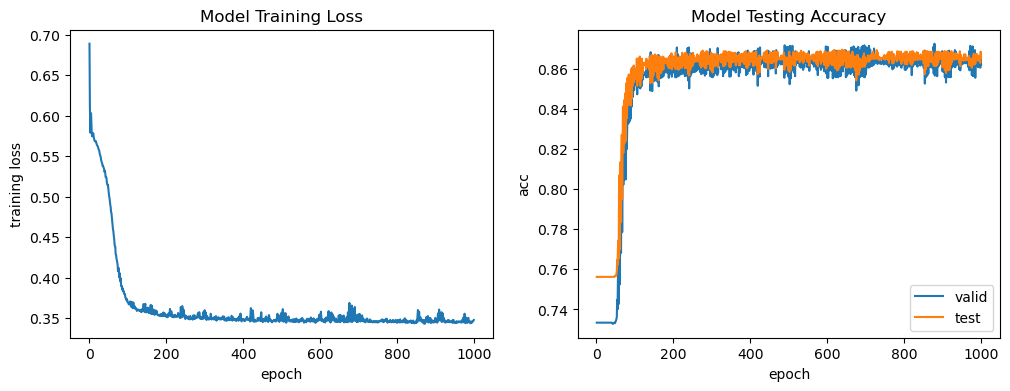

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1, n_epoch), loss_record)
plt.xlabel("epoch")
plt.ylabel("training loss")
plt.title(f"Model Training Loss")


plt.subplot(1,2,2)
plt.plot(range(1, n_epoch), val_acc_record, label='valid')
plt.plot(range(1, n_epoch), test_acc_record, label='test')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("acc")
plt.title(f"Model Testing Accuracy")
plt.savefig('plot/Github/1_GCNresult.png', dpi=300)

plt.show()